# КЛАССИФИКАЦИЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИЕЙ

## Мускатин Игорь КСм-21-1, Лаб1

### Цель: Построить модель для прогноза безопасно ли выдавать клиенту кредит

In [1]:
# pandas — программная библиотека на языке Python для обработки и анализа данных.
# подключаем для работы с данными и их обработки 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc("font", size=14)

# seaborn — это библиотека для создания статистических графиков на Python
# она основывается на matplotlib и тесно взаимодействует со структурами данных pandas
# подключаем для перевода наших данных в графическое представление
import seaborn as sns 

sns.set(style="white") # установливаем стили для графиков - seaborn
sns.set(style="whitegrid", color_codes=True)

#sklearn - библиотека программного обеспечения для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import warnings # инструмент контроля предупреждений
warnings.simplefilter('ignore') # отключаем несерьезные предупреждения

%matplotlib inline

### Загружаем данные из файла
train_data - используем в качестве тренировочного набора данных

test_data - используем для проверки 

In [2]:
train_data = pd.read_csv('Bank_data.csv')
train_data.head(5)

,Unnamed: 0,interest_rate,credit,march,may,previous,duration,y
0,0,1.334,0.0,1.0,0.0,0.0,117.0,no
1,1,0.767,0.0,0.0,2.0,1.0,274.0,yes
2,2,4.858,0.0,1.0,0.0,0.0,167.0,no
3,3,4.120,0.0,0.0,0.0,0.0,686.0,yes
4,4,4.856,0.0,1.0,0.0,0.0,157.0,no


Видим что наши данные содержат следующие характеристики:

Unnamed: 0 - ID записи

interest_rate - процентная ставка

credit - наличие кредита?

march и may - (март и май?) наличие кредита в эти месяцы?

previous - факт закрытия предыдущего кредита?/ или наличие кредита за предыдущие месяца?

duration - общая длительность погашения кредитов?

y - одобрен новый кредит или нет

In [3]:
test_data = pd.read_csv('Bank_data_testing.csv')
test_data.head(5)

,Unnamed: 0,interest_rate,credit,march,may,previous,duration,y
0,0,1.313,0.0,1.0,0.0,0.0,487.0,no
1,1,4.961,0.0,0.0,0.0,0.0,132.0,no
2,2,4.856,0.0,1.0,0.0,0.0,92.0,no
3,3,4.120,0.0,0.0,0.0,0.0,1468.0,yes
4,4,4.963,0.0,0.0,0.0,0.0,36.0,no


Удалим строку id

In [4]:
train_data = train_data.drop(train_data.columns[0], axis=1)
test_data = test_data.drop(test_data.columns[0], axis=1)
test_data.head(5)

,interest_rate,credit,march,may,previous,duration,y
0,1.313,0.0,1.0,0.0,0.0,487.0,no
1,4.961,0.0,0.0,0.0,0.0,132.0,no
2,4.856,0.0,1.0,0.0,0.0,92.0,no
3,4.120,0.0,0.0,0.0,0.0,1468.0,yes
4,4.963,0.0,0.0,0.0,0.0,36.0,no


In [5]:
print('Количество записей в наборе обучения: {}.'.format(train_data.shape[0]))

Количество записей в наборе обучения: 518.


In [6]:
print('Количество записей в тестовом наборе: {}.'.format(test_data.shape[0]))

Количество записей в тестовом наборе: 222.


В наших наборах данных могут содержаться отсутсвующие значения, по этому проверим наши наборы данных.

In [7]:
train_data.isnull().sum() 

interest_rate    0
credit           0
march            0
may              0
previous         0
duration         0
y                0
dtype: int64

In [8]:
test_data.isnull().sum() 

interest_rate    0
credit           0
march            0
may              0
previous         0
duration         0
y                0
dtype: int64

Как видим пропусков нет не в одном из наборов данных, так что приступаем к следующему шагу - Построить модель логистической регрессии

## Построение модели логистической регрессии

Для удобства работы с целевой перемееерй заменим характеристика "y" = yes/no на 1/-1

In [9]:
train_data["y"] = np.where(train_data["y"] == "yes", 1, 0)
test_data["y"] = np.where(test_data["y"] == "yes", 1, 0)
train_data.head(5)

,interest_rate,credit,march,may,previous,duration,y
0,1.334,0.0,1.0,0.0,0.0,117.0,0
1,0.767,0.0,0.0,2.0,1.0,274.0,1
2,4.858,0.0,1.0,0.0,0.0,167.0,0
3,4.120,0.0,0.0,0.0,0.0,686.0,1
4,4.856,0.0,1.0,0.0,0.0,157.0,0


<function matplotlib.pyplot.show(close=None, block=None)>

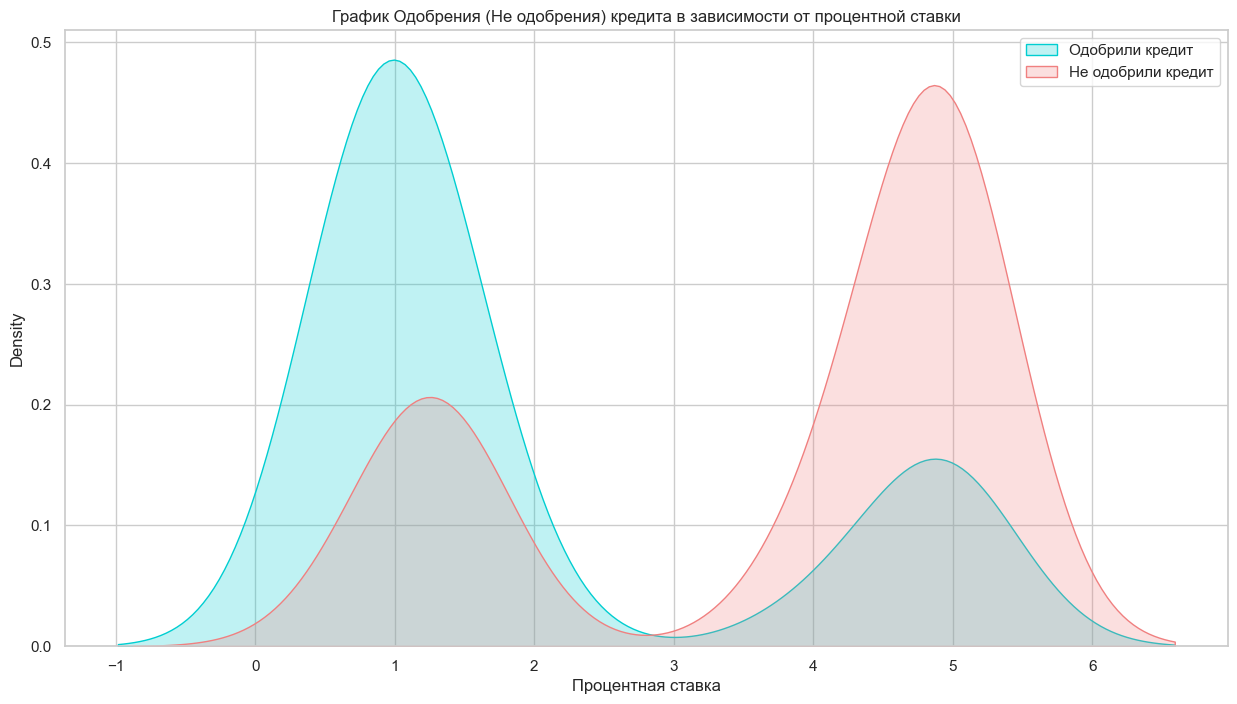

In [10]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train_data["interest_rate"][train_data.y == 1], color="darkturquoise", shade=True)
sns.kdeplot(train_data["interest_rate"][train_data.y == 0], color="lightcoral", shade=True)
plt.legend(['Одобрили кредит', 'Не одобрили кредит'])
plt.title('График Одобрения (Не одобрения) кредита в зависимости от процентной ставки')
ax.set(xlabel='Процентная ставка')

plt.show

Из графика можно сделать вывод о том, что больше кредитов одобрели с процентной ставкой ниже 3%

Также построим гистограмму чтобы посмотреть на ситуацию в другом представлении.

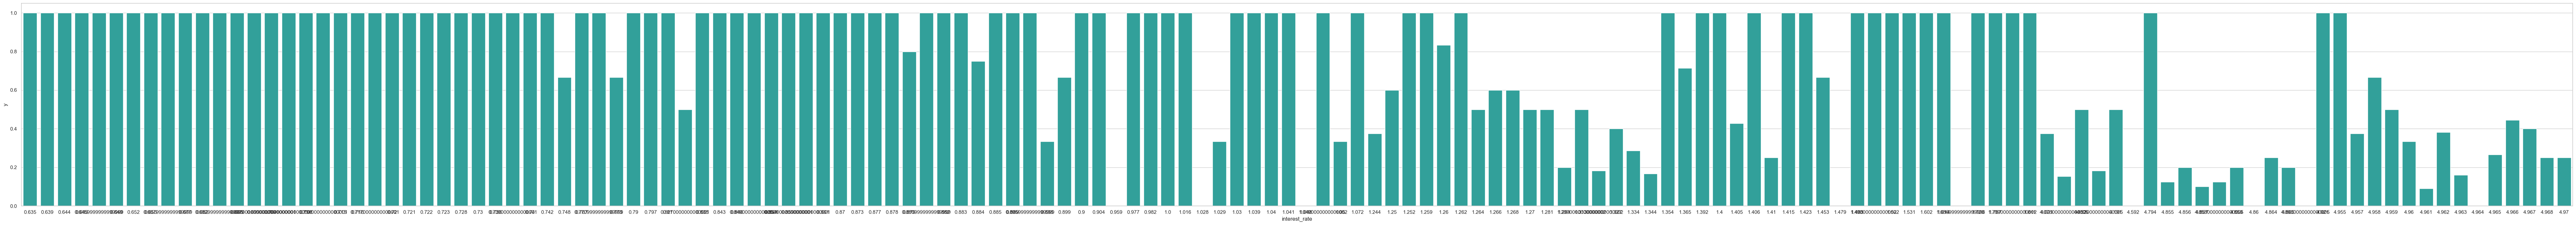

In [11]:
plt.figure(figsize=(100,8))
avg_credit = train_data[["interest_rate", "y"]].groupby(['interest_rate'], as_index=False).mean()
g = sns.barplot(x='interest_rate', y="y", data=avg_credit, color="LightSeaGreen")
plt.show()

Как видим по гистограмме, на начальном её отрезке среднее значение одобрения кредита выше чем со второй половины графика, так же при приближенном рассмотрении графика можно утверждать не было выдано кредитов с процентной ставкой от 2% до 4%, были кредиты ныже 2% и выше 4%.

Создадим новую характеристику где процентная ставка меньше 2%.

In [12]:
train_data['below2'] = np.where(train_data['interest_rate']<=2, 1, 0)
test_data['below2'] = np.where(test_data['interest_rate']<=2, 1, 0)
test_data

,interest_rate,credit,march,may,previous,duration,y,below2
0,1.313,0.0,1.0,0.0,0.0,487.0,0,1
1,4.961,0.0,0.0,0.0,0.0,132.0,0,0
2,4.856,0.0,1.0,0.0,0.0,92.0,0,0
3,4.120,0.0,0.0,0.0,0.0,1468.0,1,0
4,4.963,0.0,0.0,0.0,0.0,36.0,0,0
...,...,...,...,...,...,...,...,...
217,4.963,0.0,0.0,0.0,0.0,458.0,1,0
218,1.264,0.0,1.0,1.0,0.0,397.0,1,1
219,1.281,0.0,1.0,0.0,0.0,34.0,0,1
220,0.739,0.0,0.0,2.0,0.0,233.0,0,1


Рассмотрим распределение по duration(?время погашение кредитов?) и по одобрению кредита - 'y'

<function matplotlib.pyplot.show(close=None, block=None)>

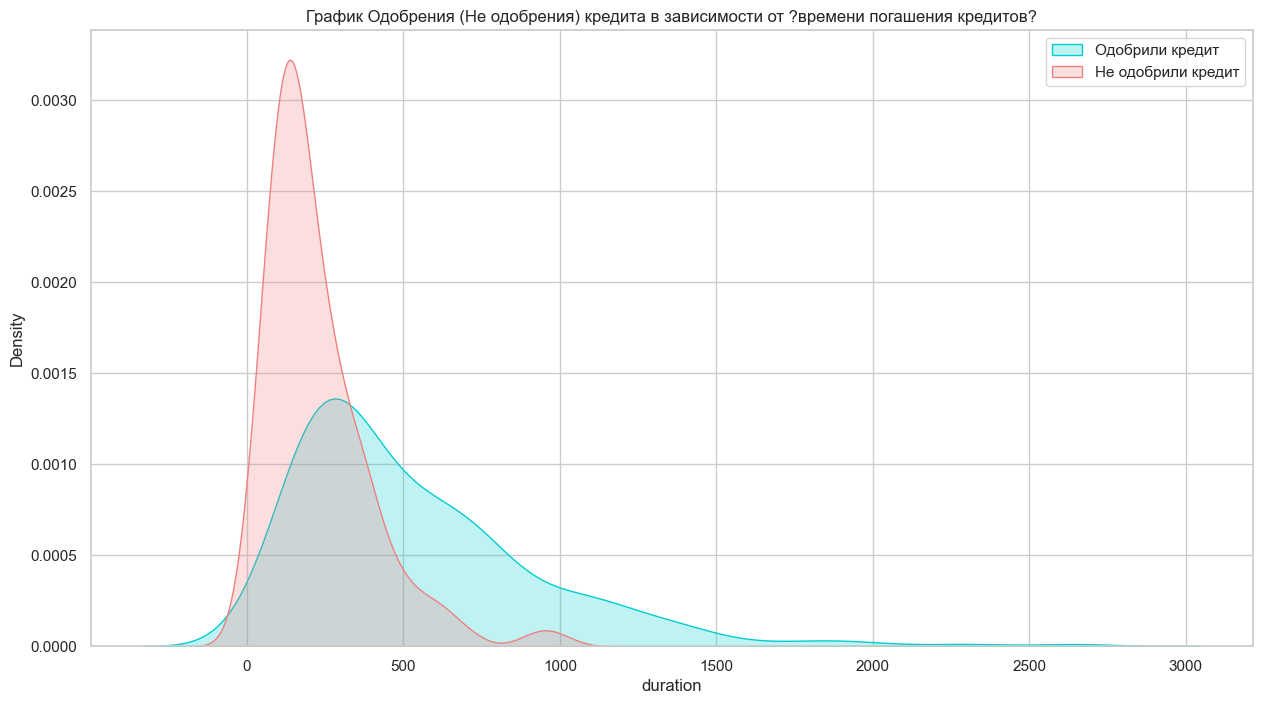

In [13]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train_data["duration"][train_data.y == 1], color="darkturquoise", shade=True)
sns.kdeplot(train_data["duration"][train_data.y == 0], color="lightcoral", shade=True)
plt.legend(['Одобрили кредит', 'Не одобрили кредит'])
plt.title('График Одобрения (Не одобрения) кредита в зависимости от ?времени погашения кредитов?')
ax.set(xlabel='duration')

plt.show

Исходя из графика и того что duration-время погашения кредитов, вероятность одобрения кредита ниже для тех у кого совсем нет кредитной истории, либо же они быстро погашают кредиты, что не совсем выгодно банкам. можно 

Если брать за истину то, что характеристика previous означает что человек уже имел кредиты в банке, то можно построить гистограмму относительно этих данных для проверки влияет ли наличие кредитной истории на желание банка одобрить кредит.

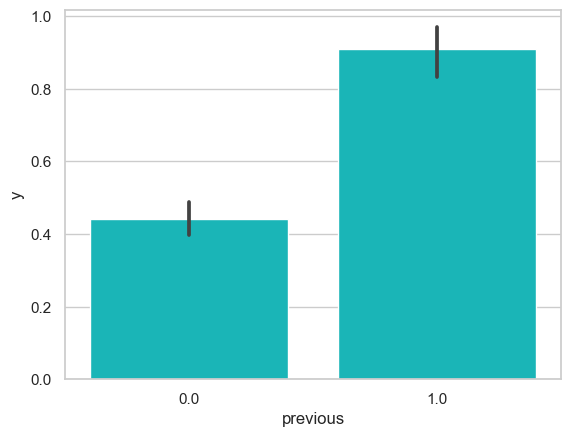

In [14]:
sns.barplot('previous', 'y', data = train_data, color="darkturquoise")
plt.show()

Как видно из гистограммы наличие кредитной истории положительно играет на перспективу одобрения нового кредита.

Далее посмотрим зависимость от характеристики 'credit', если рассматривать её как характеристику говорящую о том, что клиент уже имеет кредит.

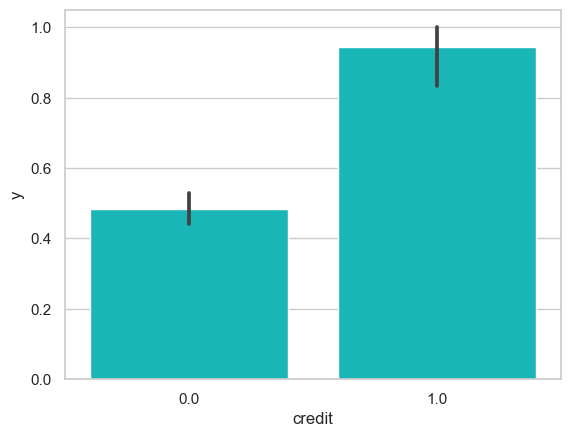

In [15]:
sns.barplot('credit', 'y', data = train_data, color="darkturquoise")
plt.show()

Исходя из графика и предположения о значении характеристики 'credit' можно предположить что банки более охотно идут на кредитование людей с уже имеющимся кредитом. Возможно это связано с тем, что банки более лояльны к тем у кого уже имеется кредит, т.к. он уже получил "одобрение" на него. Также есть вероятность того что банки более охотно выдают кредиты людям с уже имеющимися кредитами с рассчётом на то, что их кредит будет погашатся дольше, что принесет больше пользы банку.

Также рассмотрим вероятность одобрение относительно созданной нами характеристики below2 - процентная ставка ниже 2%.

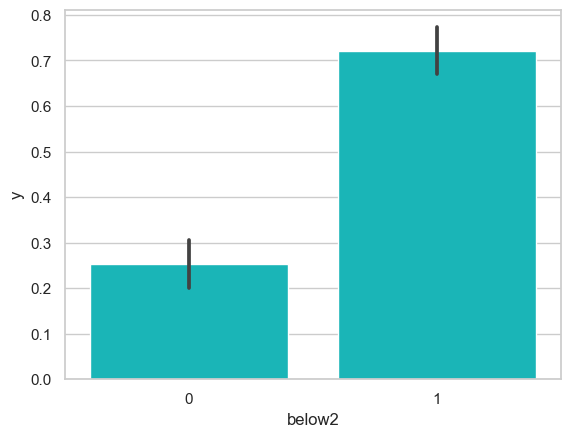

In [16]:
sns.barplot('below2', 'y', data = train_data, color="darkturquoise")
plt.show()

Как и можно было предположить банки выдают, а следовательно одобряют, кредиты под низкие проценты чаще, скорее всего это связано с тем, что людям своейственно искать пути меньших трат из-за чего больше спрос на кредиты с низкими процентными ставками, также если рассматривать это со стороны банка, возможно такие кредиты имеют больший процент погашения или большее время погашения, что полезно банкам.

### Логистическая регрессия

Выполним построение логистической регрессии

In [17]:
Selected_features = ['interest_rate', 'credit', 'march', 'may', 'previous', 'duration', 'below2']

x = train_data[Selected_features]# Независимые переменные
y = train_data['y'] #Целевая переменная

#делим на данные для обучения и теста
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=2)

#Инициализируем логистическую регрессию и смотрим с какой точностью она прогназирует результаты
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

print('Обучение/Тест результаты:')
print(logreg.__class__.__name__+" точность - %2.3f" % accuracy_score(y_test,y_pred))

Обучение/Тест результаты:
LogisticRegression точность - 0.848


### Выполним проверку методом кроссвалидации

In [18]:
logreg = LogisticRegression()
x = train_data[Selected_features]# Независимые переменные
y = train_data['y'] #Целевая переменная

scores_accuracy = cross_val_score(logreg, x, y, cv=10, scoring='accuracy')
# проводим проверку используя разбиение данных на 10 блоков, затем выводим среднее из полученных значений
print("Результат кроссвалидации - %3.2f " %scores_accuracy.mean())

Результат кроссвалидации - 0.86 


Получаем точность логистической регрессии в 0.86 или 86%, что является хорошим результатом.

## Проверка модели

Т.к. в данных test_data='Bank_data_testing.csv' присутствует столбец, который нам нужно прогназировать, то удалим его.

In [19]:
logreg = LogisticRegression()
x = train_data[Selected_features]# Независимые переменные
y = train_data['y'] #Целевая переменная
logreg.fit(x, y)

# создаем новую характеристику в наборе данных, являющуюся прогнозом одобрели кредит или нет,\
# также выведем известные нам значения для сравнения
test_data['predict_result'] = logreg.predict(test_data[Selected_features])
test_data.rename(columns={'y':'known_result'}, inplace=True) # Переименуем столбец для наглядности

prediction = test_data[['known_result', 'predict_result']]

pd.options.display.max_rows = 222
prediction['compare']  = prediction['predict_result'] == prediction['known_result']
prediction

,known_result,predict_result,compare
0,0,1,False
1,0,0,True
2,0,0,True
3,1,1,True
4,0,0,True
5,0,0,True
6,1,1,True
7,0,1,False
8,1,1,True
9,0,0,True


Зная что в тестовой выборке у нас 222 значения можно подсчитать эффективность прогноза.

In [20]:
p = prediction['compare'].sum()/test_data.shape[0]
print("Эффективность прогноза - %3.2f " %p)

Эффективность прогноза - 0.86 


Можно сделать вывод что наша модель, обученная на тренировочных данных, правильно спрогнозировала вероятность одобрения кредита в 86 случаях из 100, что можно назвать хорошим результатом.